Processing E:\newdata\img1.PNG
Noisy PSNR (P-G, Color): 29.36 dB
Noisy SSIM (P-G, Color): 0.3585
Denoised PSNR (P-G, Color): 35.27 dB
Denoised SSIM (P-G, Color): 0.8855


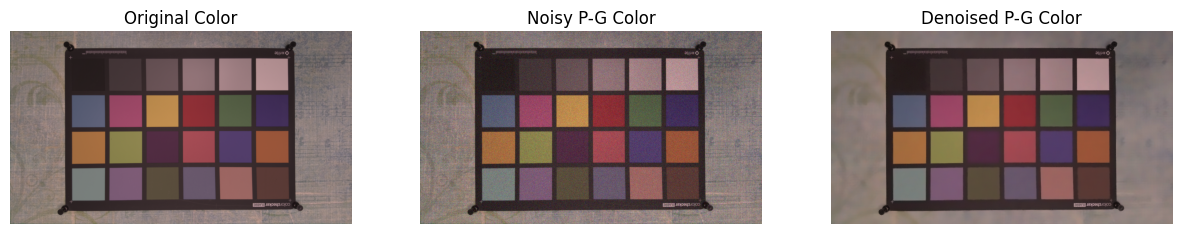

Processing E:\newdata\img2.PNG
Noisy PSNR (P-G, Color): 29.65 dB
Noisy SSIM (P-G, Color): 0.3664
Denoised PSNR (P-G, Color): 35.52 dB
Denoised SSIM (P-G, Color): 0.8677


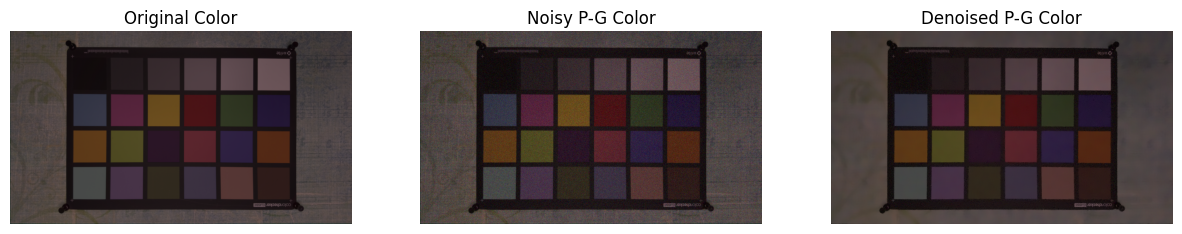

Processing E:\newdata\img3.PNG
Noisy PSNR (P-G, Color): 29.23 dB
Noisy SSIM (P-G, Color): 0.3725
Denoised PSNR (P-G, Color): 33.35 dB
Denoised SSIM (P-G, Color): 0.8540


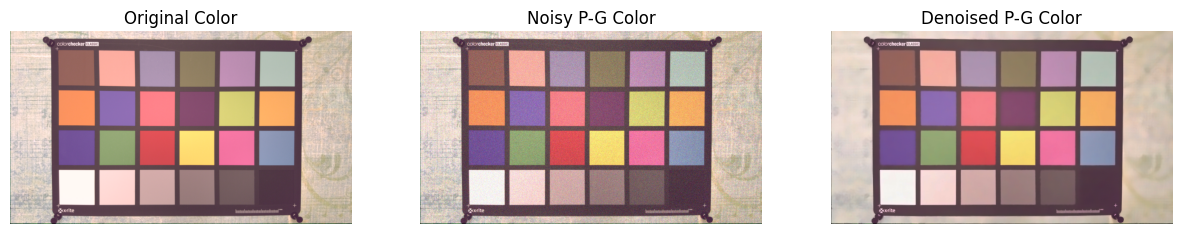

Processing E:\newdata\img4.PNG
Noisy PSNR (P-G, Color): 29.27 dB
Noisy SSIM (P-G, Color): 0.3545
Denoised PSNR (P-G, Color): 33.42 dB
Denoised SSIM (P-G, Color): 0.8139


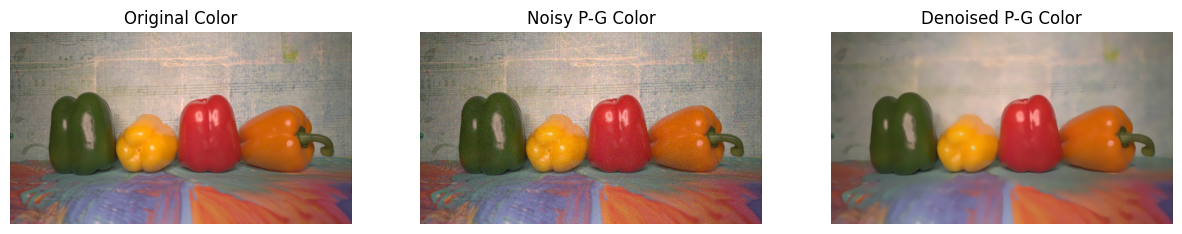

Processing E:\newdata\img5.PNG
Noisy PSNR (P-G, Color): 30.06 dB
Noisy SSIM (P-G, Color): 0.4274
Denoised PSNR (P-G, Color): 33.46 dB
Denoised SSIM (P-G, Color): 0.7572


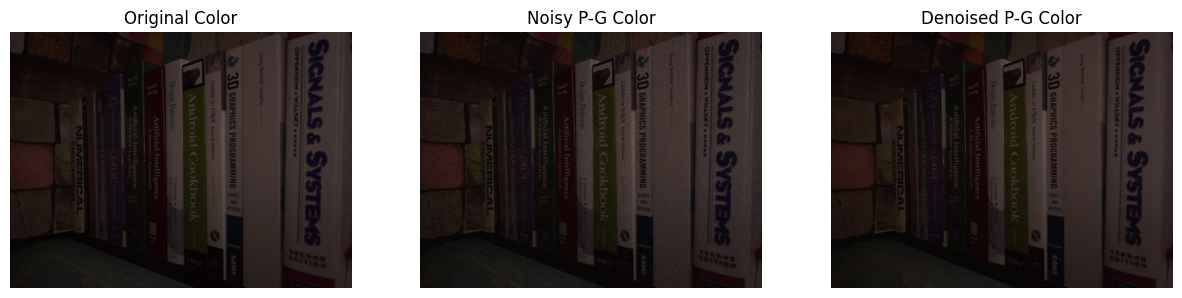

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

def ssim(original, noisy):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    original = original.astype(np.float64)
    noisy = noisy.astype(np.float64)

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(original, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(noisy, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(original ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(noisy ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(original * noisy, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    ssim_value = ssim_map.mean()

    return ssim_value

def add_poisson_gaussian_noise(image, sigma_read=10):
    image = image.astype(np.float32) / 255.0
    noisy_image_poisson = np.random.poisson(image * 255) / 255.0
    noisy_image_poisson = np.clip(noisy_image_poisson * 255, 0, 255).astype(np.uint8)
    
    noisy_image_pg = noisy_image_poisson.astype(np.float32) + np.random.normal(0, sigma_read, image.shape)
    noisy_image_pg = np.clip(noisy_image_pg, 0, 255).astype(np.uint8)
    
    return noisy_image_pg

def resize_image(image, max_dim=1024):
    height, width = image.shape[:2]
    if max(height, width) > max_dim:
        scaling_factor = max_dim / float(max(height, width))
        image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    return image


sigma_read = 10.0

dataset_folder = "E:\\newdata"
plot_count = 0
max_plots = 5

for root, _, files in os.walk(dataset_folder):
    for file in files:
        if file.startswith('img') and file.endswith('.PNG'):
            image_path = os.path.join(root, file)
            image = cv2.imread(image_path)

          
            image = resize_image(image)

            noisy_image_pg = add_poisson_gaussian_noise(image, sigma_read)

           
            denoised_image_pg = cv2.fastNlMeansDenoisingColored(noisy_image_pg, None, 10, 10, 7, 21)

            psnr_noisy_pg = psnr(image, noisy_image_pg)
            ssim_noisy_pg = ssim(image, noisy_image_pg)

            psnr_denoised_pg = psnr(image, denoised_image_pg)
            ssim_denoised_pg = ssim(image, denoised_image_pg)

   
            print(f"Processing {image_path}")
            print(f"Noisy PSNR (P-G, Color): {psnr_noisy_pg:.2f} dB")
            print(f"Noisy SSIM (P-G, Color): {ssim_noisy_pg:.4f}")
            print(f"Denoised PSNR (P-G, Color): {psnr_denoised_pg:.2f} dB")
            print(f"Denoised SSIM (P-G, Color): {ssim_denoised_pg:.4f}")

           
            if plot_count < max_plots:
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[0].set_title('Original Color')
                axes[0].axis('off')
                axes[1].imshow(cv2.cvtColor(noisy_image_pg, cv2.COLOR_BGR2RGB))
                axes[1].set_title('Noisy P-G Color')
                axes[1].axis('off')
                axes[2].imshow(cv2.cvtColor(denoised_image_pg, cv2.COLOR_BGR2RGB))
                axes[2].set_title('Denoised P-G Color')
                axes[2].axis('off')

                plt.show()
                plot_count += 1

         
            del image
            del noisy_image_pg
            del denoised_image_pg

            if plot_count >= max_plots:
                break
    if plot_count >= max_plots:
        break


Image: GT_SRGB_010.PNG
PSNR: 34.3384008727397
SSIM: 0.7446708056042585


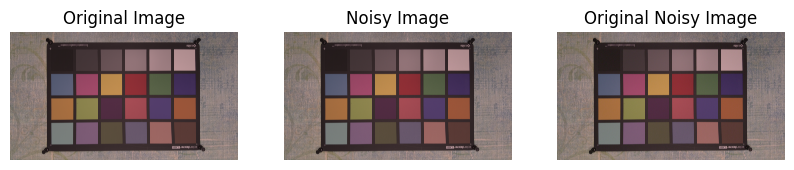

Image: GT_SRGB_010.PNG
PSNR: 31.484897148563253
SSIM: 0.6375332865919342


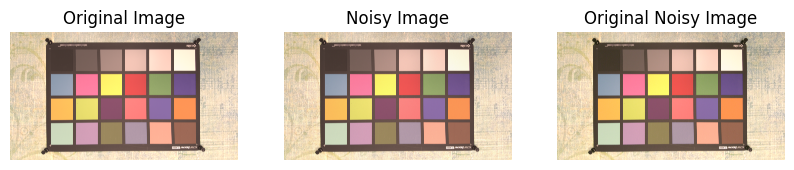

Image: GT_SRGB_010.PNG
PSNR: 34.57617160467328
SSIM: 0.7514330169177424


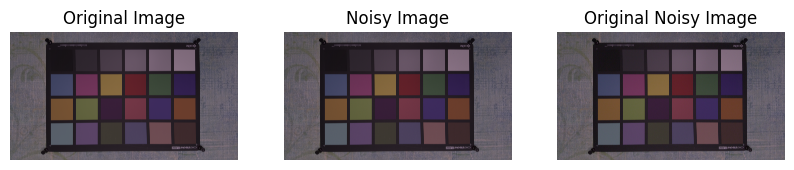

Image: GT_SRGB_010.PNG
PSNR: 30.907927823657815
SSIM: 0.592695434067787


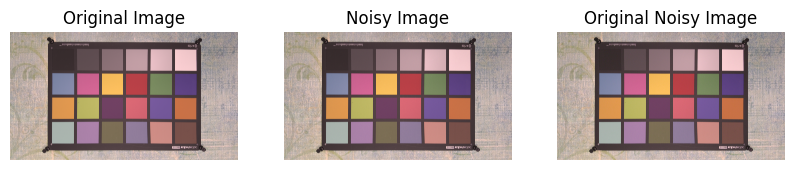

Image: GT_SRGB_010.PNG
PSNR: 31.392817715225295
SSIM: 0.6228345677059335


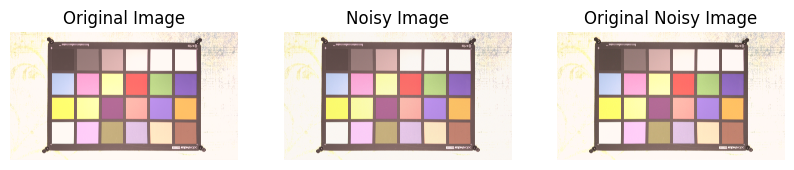

Image: GT_SRGB_010.PNG
PSNR: 34.86192494028228
SSIM: 0.760413882308484


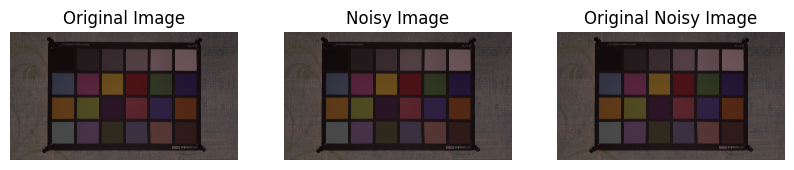

Image: GT_SRGB_010.PNG
PSNR: 31.249236077975617
SSIM: 0.6095239719608033


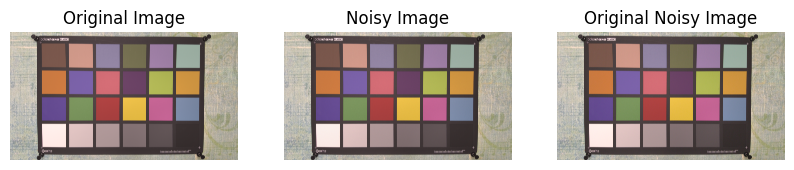

Image: GT_SRGB_010.PNG
PSNR: 32.907696718249106
SSIM: 0.6936175831223751


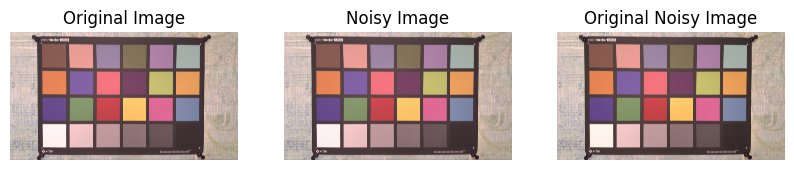

Image: GT_SRGB_010.PNG
PSNR: 34.370243164973935
SSIM: 0.7481392616539656


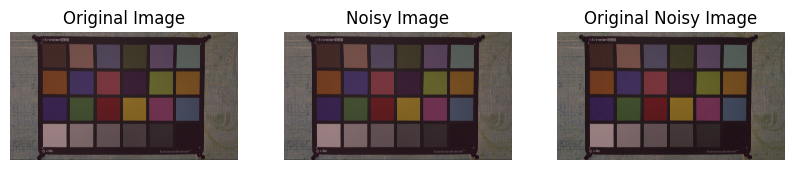

Image: GT_SRGB_010.PNG
PSNR: 33.00488032536328
SSIM: 0.7006652163304716


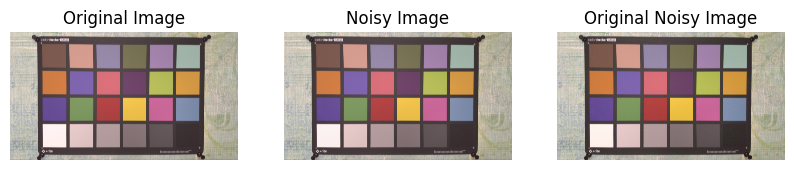

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def add_camera_noise(image, camera='ip'):
    
    
    def noise_profiles(camera):
        camera = camera.lower()
        if camera == 'ip':  # iPhone
            iso_set = [100, 200, 400, 800, 1600, 2000]
            cshot = [0.00093595, 0.00104404, 0.00116461, 0.00129911, 0.00144915, 0.00150104]
            cread = [4.697713410870357e-07, 6.904488905478659e-07, 6.739473744228789e-07,
                     6.776787431555864e-07, 6.781983208034481e-07, 6.783184262356993e-07]
        elif camera == 's6':  # Samsung S6 Edge
            iso_set = [100, 200, 400, 800, 1600, 3200]
            cshot = [0.00162521, 0.00256175, 0.00403799, 0.00636492, 0.01003277, 0.01581424]
            cread = [1.1792188420255036e-06, 1.607602896683437e-06, 2.9872611575167216e-06,
                     5.19157563906707e-06, 1.0011034196248119e-05, 2.0652668477786836e-05]
        elif camera == 'gp':  # Google Pixel
            iso_set = [100, 200, 400, 800, 1600, 3200, 6400]
            cshot = [0.00024718, 0.00048489, 0.00095121, 0.001866, 0.00366055, 0.00718092, 0.01408686]
            cread = [1.6819349659429324e-06, 2.0556981890860545e-06, 2.703070976302046e-06,
                     4.116405515789963e-06, 7.569256436438246e-06, 1.5199001098203388e-05, 5.331422827048082e-05]
        elif camera == 'sony':  # Sony A7S2
            iso_set = [800, 1600, 3200]
            cshot = [1.0028880020069384, 1.804521362114003, 3.246920234173119]
            cread = [4.053034401667052, 6.692229120425673, 4.283115294604881]
        elif camera == 'nikon':  # Nikon D850
            iso_set = [800, 1600, 3200]
            cshot = [3.355988883536526, 6.688199969242411, 13.32901281288985]
            cread = [4.4959735547955635, 8.360429952584846, 15.684213053647735]
        else:
            raise NotImplementedError("Camera not supported")
        return iso_set, cshot, cread

    def generate_poisson_(y, k=1):
        y = np.random.poisson(y / k) * k
        return y

    def generate_read_noise(shape, scale):
        read = np.random.normal(0, scale, shape)
        return read

    iso_set, k_set, read_scale_set = noise_profiles(camera)

    # Sample randomly from the noise profile parameters
    i = np.random.choice(len(k_set))
    k, read_scale = k_set[i], read_scale_set[i]

    # Normalize image to [0, 1]
    image = image.astype(np.float32) / 255.0

    #  shot noise (Poisson)
    noisy_shot = generate_poisson_(image, k)
    noisy_shot = np.clip(noisy_shot, 0, 1)

    #  read noise (Gaussian)
    read_noise = generate_read_noise(image.shape, read_scale)
    
    #  shot noise and read noise
    noisy_image = noisy_shot + read_noise

    noisy_image = np.clip(noisy_image * 255, 0, 255).astype(np.uint8)
    
    return noisy_image

max_count = 0

# Process images in a folder
def process_images_in_folder(folder_path, camera='ip', output_folder='noisy_images'):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.startswith('GT_SRGB_010') and file.endswith('.PNG'):
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)
                noisy_image = add_camera_noise(image, camera)

                output_path = os.path.join(output_folder, file)
                cv2.imwrite(output_path, noisy_image)

                #  PSNR and SSIM
                original_noisy_image_path = os.path.join(root, file.replace('GT_SRGB', 'NOISY_SRGB'))
                if os.path.exists(original_noisy_image_path):
                    original_noisy_image = cv2.imread(original_noisy_image_path)

                    psnr_value = psnr(image, noisy_image)
                    ssim_value = ssim(image, noisy_image, win_size=5, channel_axis=2)

                    print(f"Image: {file}")
                    print(f"PSNR: {psnr_value}")
                    print(f"SSIM: {ssim_value}")

                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 3, 1)
                    plt.title("Original Image")
                    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.title("Noisy Image")
                    plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.title("Original Noisy Image")
                    plt.imshow(cv2.cvtColor(original_noisy_image, cv2.COLOR_BGR2RGB))
                    plt.axis('off')

                    plt.show()
                else:
                    print(f"Original noisy image not found for: {file}")

                global max_count
                max_count += 1
                if max_count == 10:
                    break
        if max_count == 10:
            break

# Example usage:
if __name__ == '__main__':
    folder_path = 'E:\\archive (1)\\SIDD_Small_sRGB_Only\\Data'
    process_images_in_folder(folder_path, camera='ip')
